In [1]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, Visualization_Setting, set_figure_label_and_limit, contact_optimization, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
# rod_length = curved_linkage.totalRestLength() / curved_linkage.numSegments()
rod_length = 0.11031757615154746
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
scale = 1
io = InputOrganizer('costa_min_{}'.format(scale), thickness, width, weaving_dir)

0.03677252538384915 0.00257407677686944


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False

In [5]:
rw = 0.01
sw = 0.01

In [6]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False, width_scale=[0.8, 1.2])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [7]:
set_surface_view_options(curved_linkage_view, surface_transparent=False)

In [8]:
ribbons = order_segments_by_ribbons(curved_linkage)
len(ribbons)

48

In [8]:
iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [9]:
# fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)
fixed_boundary_joints = []

In [10]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [11]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	0.000143327	0.000316751	0.000316751	1	0
1	0.000142122	0.000528514	0.000528514	1	0
2	0.000142076	6.63365e-06	6.63365e-06	1	0
3	0.000142076	1.86509e-07	1.86509e-07	1	0


In [12]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


In [13]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

2.6072293112170142e-05


In [14]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [15]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [16]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

Min Width  0.02941802030707932
num seg per rod 10
num seg per rod 32
num seg per rod 21
num seg per rod 10
num seg per rod 32
num seg per rod 11
num seg per rod 10
num seg per rod 24
num seg per rod 10
num seg per rod 21
num seg per rod 32
num seg per rod 11
num seg per rod 11
num seg per rod 72
num seg per rod 15
num seg per rod 15
num seg per rod 24
num seg per rod 15
num seg per rod 11
num seg per rod 24
num seg per rod 11
num seg per rod 10
num seg per rod 11
num seg per rod 10
num seg per rod 11
num seg per rod 10
num seg per rod 10
num seg per rod 11
num seg per rod 10
num seg per rod 10
num seg per rod 10
num seg per rod 21
num seg per rod 10
num seg per rod 21
num seg per rod 13
num seg per rod 13
num seg per rod 13
num seg per rod 13
num seg per rod 10
num seg per rod 10
num seg per rod 10
num seg per rod 15
num seg per rod 24
num seg per rod 11
num seg per rod 11
num seg per rod 11
num seg per rod 10
num seg per rod 11


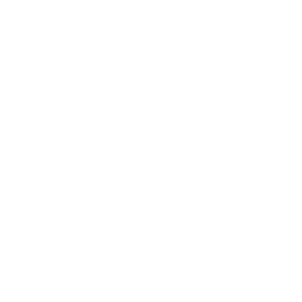

In [17]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)

../../../../../elastic_rods/python/structural_analysis.py:209: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


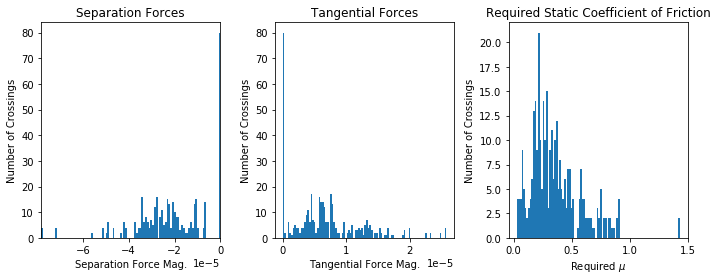

In [18]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()